In [307]:
from ipywidgets import widgets, HBox, VBox, Layout
from IPython.display import display
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [313]:
def get_next_turn(active_turn):
    # Change player
    # 1 -> o
    #-1 -> x
    if active_turn == 1:
        next_turn = -1
    else:
        next_turn = 1
    return next_turn

def score(matrix, i_am, depth):
    points = 10
    status = game_status(matrix)
    if status == 0:
        return 0
    if status == i_am:
        return points - depth
    if status != i_am:
        return depth - points
    
def get_childs(matrix, turn):
    # turn is 1 or -1
    # 1 -> o
    #-1 -> x
    # 0 -> Free space
    # return all posible plays for user 'turn' ('x' or 'o')
    N = 3
    childs = []
    for i in range(N):
        for j in range(N):
            if matrix[i,j] == 0 :
                child = matrix.copy()
                child[i, j] = turn
                childs.append(child) 
    return childs

def game_status(matrix):    
    # Returns 1 if 'o' win, -1 if 'x' win, 0 if draw 
    points = 1
    if (matrix[0, :].sum() == 3) | (matrix[1, :].sum() == 3) | (matrix[2, :].sum() == 3) | (matrix[:, 0].sum() == 3) | (matrix[:, 1].sum() == 3) | (matrix[:, 2].sum() == 3):
        return points
    if (matrix[0, 0] == matrix[1, 1]) & (matrix[2, 2] == matrix[1, 1]) & (matrix[0, 0] == 1):
        return points
    if (matrix[0, 2] == matrix[1, 1]) & (matrix[2, 0] == matrix[1, 1]) & (matrix[2, 0] == 1):
        return points
    if (matrix[0, :].sum() == -3) | (matrix[1, :].sum() == -3) | (matrix[2, :].sum() == -3) | (matrix[:, 0].sum() == -3) | (matrix[:, 1].sum() == -3) | (matrix[:, 2].sum() == -3):
        return -points
    if (matrix[0, 0] == matrix[1, 1]) & (matrix[2, 2] == matrix[1, 1]) & (matrix[0, 0] == -1):
        return -points
    if (matrix[0, 2] == matrix[1, 1]) & (matrix[2, 0] == matrix[1, 1]) & (matrix[2, 0] == -1):
        return -points
    return 0

def game_over(matrix):
    # status <- Returns 1 if 'o' win, -1 if 'x' win, 0 if draw 
    # game_finished: true is game is over
    game_finished = False
    status = game_status(matrix)
    if status != 0:
        #Game finishes, someone won
        game_finished = True
    if abs(matrix).sum() == 9:
        #No more moves
        game_finished = True
    return game_finished, status

def maximize(matrix, active_turn, player, depth, alpha, beta, nodes_visited):
    game_finished,_ = game_over(matrix)
    if game_finished:
        return None, score(matrix, player, depth), nodes_visited
    depth += 1
    
    infinite_number = 100000
    maxUtility = -infinite_number
    choice = None
    
    childs = get_childs(matrix, active_turn)
    for child in childs:
        nodes_visited = nodes_visited + 1
        _, utility, nodes_visited = minimize(child, get_next_turn(active_turn), player, depth, alpha, beta, nodes_visited)
        
        if utility > maxUtility:
            choice = child
            maxUtility = utility
                
        if maxUtility >= beta:
            break
        if maxUtility > alpha:
            alpha = maxUtility
    return choice, maxUtility, nodes_visited

def minimize(matrix, active_turn, player, depth, alpha, beta, nodes_visited):
    game_finished,_ = game_over(matrix)
    if game_finished:
        return None, score(matrix, player, depth), nodes_visited
    depth += 1
    infinite_number = 100000
    minUtility = infinite_number
    choice = None
    
    childs = get_childs(matrix, active_turn)
    for child in childs:
        nodes_visited = nodes_visited + 1
        _, utility, nodes_visited = maximize(child, get_next_turn(active_turn), player, depth, alpha, beta, nodes_visited)
        
        if utility < minUtility:
            choice = child
            minUtility = utility
            
        if minUtility <= alpha:
            break
        if minUtility < beta:
            beta = minUtility
    return choice, minUtility, nodes_visited

def minimax(matrix, player):
    infinite_number = 1000
    alpha = -infinite_number
    beta = infinite_number
    choice, score, nodes_visited = maximize(matrix, player, player, 0, alpha, beta, 0)
    return choice, score, nodes_visited

def draw_graph():
    plt.rcParams['font.family'] = 'Consolas'

    plt.rcParams['font.size'] = 12

    plt.rcParams['font.style'] = 'normal'

    score = pd.read_csv('ranking-board.csv')

    score = score.sort_values(by = ['winsRate'])

    col = ('black', 'purple', 'blue', 'green', 'orange', 'brown', 'red')

    plt.figure(figsize=(6, 4))
    plt.title('RANKING BOARD')
    plt.barh(score['username'].head(7), score['winsRate'].head(7), color = col)
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    plt.show()

    score = score.sort_val

In [314]:
class General_functions(object):   
    def __init__(self, matrix, actual_turn, username):
        self.N = 3
        self.button_list = None
        self.text_box = None
        self.matrix = matrix
        self.game_finished = False
        self.actual_turn = actual_turn
        self.username = username
                
    def display_matrix(self):
        N = self.N
        childs = []
        for i in range(N):
            for j in range(N):
                if self.matrix[i, j] == 1:
                    self.button_list[i * N + j].description = 'o'
                if self.matrix[i, j] == -1:
                    self.button_list[i * N + j].description = 'x'

    def on_button_clicked(self, index, button):
        N = self.N

        if self.game_finished:
            return

        y = index % N
        x = int(index / N)
        if self.matrix[x, y] != 0:
            self.text_box.value = '거긴 못 놓음ㅋ'
            return
        button.description = self.actual_turn[0]

        if self.actual_turn == 'o':
            self.matrix[x, y] = 1
            self.game_finished, status = game_over(self.matrix)
            if self.game_finished:
                if (status != 0):
                    self.text_box.value = 'o 승'
                else: 
                    self.text_box.value = '무승부'
            else:
                self.actual_turn = 'x'
                self.text_box.value = self.actual_turn + ' 차례' 
        else:
            self.matrix[x,y] = -1
            self.game_finished, status = game_over(self.matrix)
            if self.game_finished:
                if (status != 0):
                    self.text_box.value = 'x 승'
                else: 
                    self.text_box.value = '무승부'
            else:
                self.actual_turn = 'o'
                self.text_box.value = self.actual_turn + ' 차례' 
        self.computer_play()
        
    def draw_board(self):
        self.text_box = widgets.Text(value = self.actual_turn + ' 차례', layout = Layout(width = '129px', height = '40px'))
        self.button_list = []
        for i in range(9):
            button = widgets.Button(description = '',
            disabled = False,
            button_style = '', # 'success', 'info', 'warning', 'danger' or ''
            tooltip = 'Click me',
            icon = '',
            layout = Layout(width = '40px', height = '40px'))
            self.button_list.append(button)
            button.on_click(partial(self.on_button_clicked, i))
        tic_tac_toe_board = VBox([HBox([self.button_list[0], self.button_list[1], self.button_list[2]]),
                HBox([self.button_list[3], self.button_list[4], self.button_list[5]]),
                HBox([self.button_list[6], self.button_list[7], self.button_list[8]])])
        display(VBox([self.text_box, tic_tac_toe_board]))
        return

    def computer_play(self):
        score = pd.read_csv('ranking-board.csv')
        
        if self.game_finished:
            return
        
        if self.actual_turn == 'x':
            turn = -1
            next_turn = 'o'
            
        if self.actual_turn == 'o':
            turn = 1
            next_turn = 'x'
            
        self.matrix = self.get_best_play(turn)
        self.display_matrix()
        self.actual_turn = next_turn
        self.text_box.value = self.actual_turn + ' 차례'
        self.game_finished, status = game_over(self.matrix)
        
        # status <- Returns 1 if 'o' win, -1 if 'x' win, 0 if draw 
        # game_finished: true is game is over
        # if usericon 'o', status returns 1 => user win
        # if usericon 'o', status returns -1 => computer win        
        # if usericon 'o' or 'x', status returns 0 => draw
        # if usericon 'x', status returns -1 => user win
        # if usericon 'x', status returns 1 => computer win                
        if self.game_finished:  
            if (getattr(score, 'username').isin([self.username]).any() == False):
                new_row = pd.Series([self.username, 0, 0, 0, 0.0], index = score.columns)
                score = score.append(new_row, ignore_index = True)

            if (self.actual_turn == 'o'):
                if (status == 1):
                    self.text_box.value = self.username + ' 승'
                    score.loc[score['username'] == self.username, 'wins'] += 1
                elif (status == -1):
                    self.text_box.value = '컴퓨터 승'
                    score.loc[score['username'] == self.username, 'defeats'] += 1
                else:
                    self.text_box.value = '무승부'
                    score.loc[score['username'] == self.username, 'draws'] += 1                    
            elif (self.actual_turn == 'x'):
                if (status == 1):
                    self.text_box.value = '컴퓨터 승'
                    score.loc[score['username'] == self.username, 'defeats'] += 1
                elif (status == -1):
                    self.text_box.value = self.username + ' 승'
                    score.loc[score['username'] == self.username, 'wins'] += 1
                else:
                    self.text_box.value = '무승부'
                    score.loc[score['username'] == self.username, 'draws'] += 1
                    
            wins = score[score['username'] == username]['wins']
            defeats = score[score['username'] == username]['defeats']
            draws = score[score['username'] == username]['draws']
            userWinsRate = format(float(wins / (wins + defeats + draws) * 100), ".2f")
            score.loc[score['username'] == self.username, 'winsRate'] = userWinsRate
            score.to_csv('ranking-board.csv', encoding = 'utf-8-sig', index = False)       

    def get_best_play(self, turn):
        # 1000 is an infinite value compared with the highest cost of 10 that we can get
        choice, points, nodes_visited = minimax(self.matrix, turn)
        print('points:', points)
        print('nodes_visited:', nodes_visited)
        return choice 

In [315]:
def start_game(computer_starts = True, user_icon = 'x', start_mode = 'center'):
    username = input("username")
    matrix = np.zeros((3, 3))
    
    if user_icon == 'x':
        computer_icon_representation = 1
    else:
        computer_icon_representation = -1
        
    GF = General_functions(matrix, user_icon, username)
    GF.draw_board()

    if computer_starts:
        if start_mode == 'center':
            matrix[1, 1] = computer_icon_representation
        elif start_mode == 'minimax':
            GF.computer_play()
        elif start_mode == 'random':
            x = np.random.randint(3)
            y = np.random.randint(3)
            matrix[x, y] = computer_icon_representation

    GF.display_matrix()

In [316]:
# start_mode:
# 'minimax': 첫 위치 선택 가능
# 'center': 센터에서 시작
# 'random': 랜덤 위치에서 시작
# user_icon:
#  'x' or 'o'
# computer_starts: True or False

print(score)
start_game(computer_starts = True, user_icon = 'o', start_mode = 'random')


<function score at 0x00000200894C9580>
usernamehayan2


points: 0
nodes_visited: 1918
points: 0
nodes_visited: 121
points: 0
nodes_visited: 13
points: 9
nodes_visited: 1


In [320]:
plt.rcParams['font.family'] = 'Consolas'

plt.rcParams['font.size'] = 12

plt.rcParams['font.style'] = 'normal'

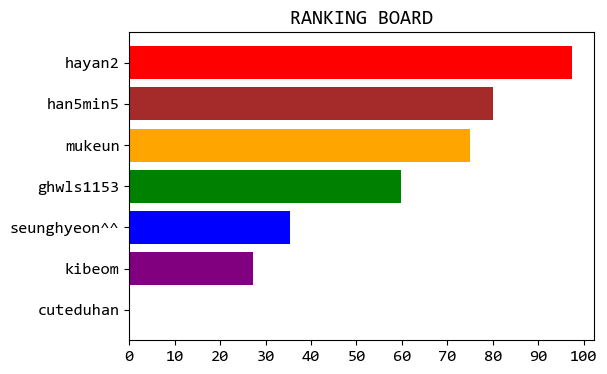

,username,wins,defeats,draws,winsRate
0,hayan2,152,4,0,97.440000
2,han5min5,56,13,1,80.000000
6,mukeun,27,8,1,75.000000
3,ghwls1153,85,52,5,59.859155
4,seunghyeon^^,12,16,6,35.294118
5,kibeom,33,81,7,27.272727
1,cuteduhan,0,2005,6,0.000000


In [324]:
score = pd.read_csv('ranking-board.csv')

score = score.sort_values(by = ['winsRate'])

col = ('black', 'purple', 'blue', 'green', 'orange', 'brown', 'red')

plt.figure(figsize=(6, 4))
plt.title('RANKING BOARD')
plt.barh(score['username'].head(7), score['winsRate'].head(7), color = col)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.show()

score = score.sort_values(by = ['winsRate'], ascending = False)
score